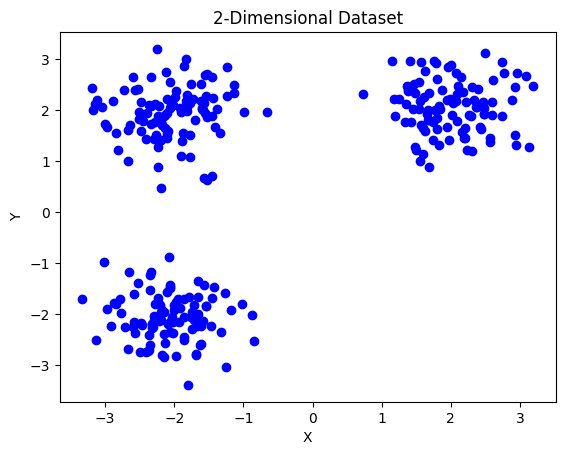

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data
np.random.seed(0)
points = np.concatenate([
    np.random.randn(100, 2) * 0.5 + np.array([2, 2]),
    np.random.randn(100, 2) * 0.5 + np.array([-2, -2]),
    np.random.randn(100, 2) * 0.5 + np.array([-2, 2])
])

x = points[:, 0]
y = points[:, 1]

# Plot the data
plt.scatter(points[:, 0], points[:, 1], color='b')
plt.title("2-Dimensional Dataset")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [2]:
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder \
    .appName("CosineKMeansExample") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/29 16:36:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql.types import StructType, StructField, FloatType

# Define the schema of the DataFrame
schema = StructType([
    StructField("x1", FloatType(), nullable=False),
    StructField("x2", FloatType(), nullable=False)
])

# Create a Spark DataFrame from the points
data = spark.createDataFrame(points.tolist(), schema)


In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=["x1", "x2"], outputCol="features")
data = assembler.transform(data)

# Create and fit the KMeans model
euclid_kmeans = KMeans(k=3, featuresCol="features")
cosine_kmeans = KMeans(k=3, featuresCol="features", distanceMeasure="cosine")
euclid_model = euclid_kmeans.fit(data)
cosine_model = cosine_kmeans.fit(data)

23/06/29 16:36:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [5]:
# Add the cluster assignment to the DataFrame
euclid_predictions = euclid_model.transform(data)
cosine_predictions = cosine_model.transform(data)

# Get the cluster centers
euclid_centers = euclid_model.clusterCenters()
cosine_centers = cosine_model.clusterCenters()

# Extract the cluster assignment and convert it to a list
euclid_cluster_assignments = euclid_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
cosine_cluster_assignments = cosine_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

In [6]:
euclid_model.clusterCenters()

[array([-2.05617876,  1.94843116]),
 array([-2.07153916, -2.05647532]),
 array([1.99952117, 2.07138934])]

In [7]:
cosine_model.clusterCenters()

[array([-0.72702501,  0.68661097]),
 array([-0.70844391, -0.70576712]),
 array([0.69532744, 0.71869308])]

In [8]:
euclid_predictions.select("features").rdd.flatMap(lambda x: x).collect()[:7]

[DenseVector([2.882, 2.2001]),
 DenseVector([2.4894, 3.1204]),
 DenseVector([2.9338, 1.5114]),
 DenseVector([2.475, 1.9243]),
 DenseVector([1.9484, 2.2053]),
 DenseVector([2.072, 2.7271]),
 DenseVector([2.3805, 2.0608])]

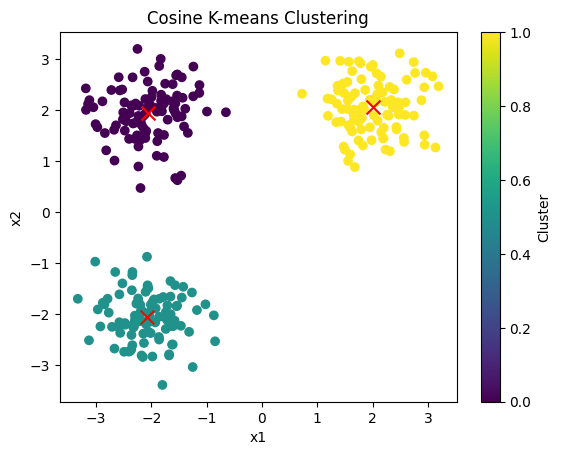

In [9]:
# Euclidean::::Plot the points with different colors based on the cluster assignments
import matplotlib
cmap = matplotlib.colormaps.get_cmap('viridis')

plt.scatter(x, y, c=euclid_cluster_assignments, cmap=cmap)
plt.scatter([c[0] for c in euclid_centers], [c[1] for c in euclid_centers], marker='x', color='red', s=100)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Cosine K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()


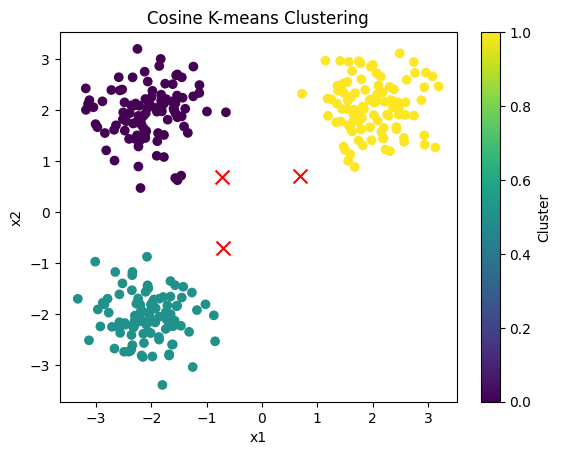

In [10]:
# Cosine::::Plot the points with different colors based on the cluster assignments
cmap = matplotlib.colormaps.get_cmap('viridis')

plt.scatter(x, y, c=cosine_cluster_assignments, cmap=cmap)
plt.scatter([c[0] for c in cosine_centers], [c[1] for c in cosine_centers], marker='x', color='red', s=100)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Cosine K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()


In [11]:
### Cosine KMean with sklearn

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import normalize
import numpy as np

# Normalize the vectors to unit length
normalized_points = normalize(points)

# Compute cosine distances instead of Euclidean distances
cosine_kmeans = KMeans(n_clusters=3)
cosine_kmeans.fit(normalized_points)

# Get the cluster assignments for each vector
cluster_assignments = cosine_kmeans.labels_
cluster_centers = cosine_kmeans.cluster_centers_

# Print the cluster assignments for each vector
for i, vector in enumerate(points[:5]):
    print(f"Vector: {vector} | Cluster: {cluster_assignments[i]}")

/N/u/zfwei/BigRed200/.conda/envs/mm2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Vector: [2.88202617 2.2000786 ] | Cluster: 1
Vector: [2.48936899 3.1204466 ] | Cluster: 1
Vector: [2.933779   1.51136106] | Cluster: 1
Vector: [2.47504421 1.9243214 ] | Cluster: 1
Vector: [1.94839057 2.20529925] | Cluster: 1


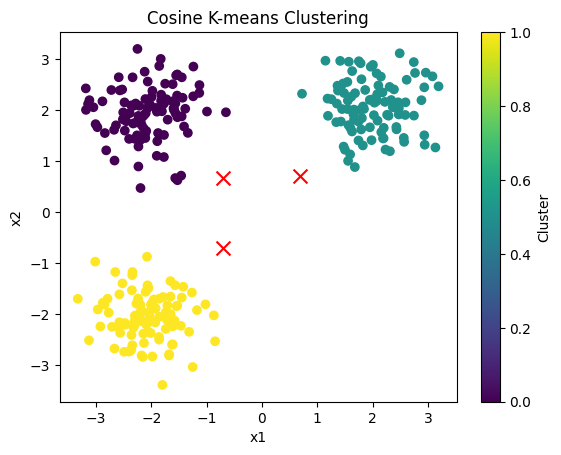

In [12]:
### Sklearn Cosine::::Plot the points with different colors based on the cluster assignments
cmap = matplotlib.colormaps.get_cmap('viridis')

plt.scatter(x, y, c=cluster_assignments, cmap=cmap)
plt.scatter([c[0] for c in cluster_centers], [c[1] for c in cluster_centers], marker='x', color='red', s=100)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Cosine K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()

In [13]:
### This shows the centers with sklearn cosine Kmean
cosine_centers

[array([-0.72702501,  0.68661097]),
 array([-0.70844391, -0.70576712]),
 array([0.69532744, 0.71869308])]

In [14]:
### This shows the centers with PySparl cosine Kmean
cluster_centers

array([[-0.71271876,  0.67309998],
       [ 0.6842372 ,  0.70723016],
       [-0.69838101, -0.69574225]])